# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
from pymatgen.ext.matproj import MPRester
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

**Data exploration**

In [225]:
def dataset_info(dataset):
    print(dataset.head())
    print(dataset.columns)
    print(dataset.describe())
    print(dataset.info())

**Data cleaning functions**

In [226]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [227]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
    return entropy_data

**Launching cleaning functions on datasets**

In [243]:
#Launching functions
initial_df = parse_Nan(initial_df)
dataset_info(initial_df)
entropy_data = column_cleaning(initial_df)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
#entropy_data['ΔGOOH*-ΔGOH*'] = entropy_data['ΔGOOH*'] - entropy_data['ΔGOH*']
#Slicing only data with values for required columns, then plotting dataset
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
#print(entropy_data.describe())

  Catalyst Materials                           Family  \
0    (Mn-Co-Ta-Sb)Ox                                0   
1         [Mo2S12]2-  Transition metal dichalcogenide   
2            1T-MoS2                                0   
3             AgAlO3                       Perovskite   
4             AgBiO3                       Perovskite   

                                           Substrate  \
0                      (Mn-Co-Ta-Sb)Ox loaded on FTO   
1                                                  0   
2  Exfoliated 2D 1T phase molybdenum disulfide lo...   
3                                                  0   
4                                                  0   

  Operating Conditions (T, pH, potential)  Valence state, A  Valence state, B  \
0                                1M H2SO4               0.0               0.0   
1                            Acidic media               0.0               0.0   
2                            0.5 M H2SO4                0.0               0.0

**Element composition featurisation**

In [229]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
entropy_data = str_comp.featurize_dataframe(entropy_data, col_id='Catalyst Materials')
#print(entropy_data)

StrToComposition: 100%|██████████| 831/831 [00:19<00:00, 43.38it/s] 


**Accessing material ID from material project + other properties**

In [230]:
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap','formation_energy_per_atom'])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap,result.formation_energy_per_atom) for result in results]
    #print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:00<00:00, 3396.48it/s]


In [231]:
#Sorting chemical compositions in formulas alphabetically

def alph_order(composition):
    new_formula = []
    for i in composition:
        first= []
        second= []
        temp = list(i)
        running = True
        capital_pos=[]
        for x in range(0, len(temp)):
            if temp[x].isupper() == True:
                capital_pos.append(x)
        for y in range(capital_pos[0], capital_pos[1]):
                first.append(temp[y])
        for z in range(capital_pos[1], len(temp)):
                second.append(temp[z])
        first = ''.join(str(v) for v in first)
        second = ''.join(str(v) for v in second)
        compound = ''.join(str(v) for v in first)
        compound = second+first+"O3"
        new_formula.append(compound)
    return new_formula
#This function is to delete the extra O3 placed in the formulas

def remove_O3(composition):
    return [i.replace("O3", "") for i in composition]

def add_o3(composition):
    return [i + "O3" for i in composition]



**Sorting list to a dictionary**

In [232]:
formula = []
material_id = []
band_gap = []
composition = []
for i in data_list:
    material_id.append(i[0])
    formula.append(i[1])
    band_gap.append(i[2])
    composition.append(i[3])
#Creating dictionary
#print(composition)
material_proj_data = dict((z[0], list(z[1:])) for z in zip(formula, material_id, band_gap, composition))
#print(material_proj_data)
rearranged_formula = alph_order(formula)
rearranged_formula = remove_O3(rearranged_formula)
rearranged_formula = add_o3(rearranged_formula)
#Creating dictionary for re-arranged formulae
material_proj_data_rearranged = dict((z[0], list(z[1:])) for z in zip(rearranged_formula, material_id, band_gap, composition))
material_proj_data.update(material_proj_data_rearranged)

**Dictionary to pandas dataframe + merge with original dataset**

In [233]:
material_proj_df = pd.DataFrame.from_dict(material_proj_data, orient= 'index')
material_proj_df = material_proj_df.reset_index()
material_proj_df.columns = ["Catalyst Materials", "material id", "band gap","composition"]
entropy_data = entropy_data.merge(material_proj_df, on ='Catalyst Materials', how= 'left')
print(entropy_data)
entropy_data.to_excel("output.xlsx",sheet_name='Sheet_name_1') 

    Catalyst Materials      Family  ΔGOH*  ΔGO*  ΔGOOH*  \
0               AgAlO3  Perovskite   2.18  4.63    5.10   
1               AgBiO3  Perovskite   1.09  3.37    4.23   
2               AgCoO3  Perovskite   1.59  3.28    4.66   
3               AgCrO3  Perovskite   0.83  2.36    4.26   
4               AgCuO3  Perovskite   1.80  4.36    4.79   
..                 ...         ...    ...   ...     ...   
826              YTaO3  Perovskite  -0.34  1.06    3.24   
827              YTiO3  Perovskite   1.49  3.97    4.61   
828               YUO3  Perovskite   0.81  2.59    4.09   
829               YVO3  Perovskite   0.61  1.70    3.90   
830              YZnO3  Perovskite   1.74  5.03    4.54   

     Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
0                                                 1.82             2.45   
1                                                 1.55             2.28   
2                                                 0.92            

**Dataset exploration after importing data**

In [234]:
dataset_info(entropy_data)

  Catalyst Materials      Family  ΔGOH*  ΔGO*  ΔGOOH*  \
0             AgAlO3  Perovskite   2.18  4.63    5.10   
1             AgBiO3  Perovskite   1.09  3.37    4.23   
2             AgCoO3  Perovskite   1.59  3.28    4.66   
3             AgCrO3  Perovskite   0.83  2.36    4.26   
4             AgCuO3  Perovskite   1.80  4.36    4.79   

   Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
0                                               1.82             2.45   
1                                               1.55             2.28   
2                                               0.92             1.69   
3                                               1.31             1.53   
4                                               1.38             2.56   

   ΔGOOH*-ΔGOH* composition_x material id  band gap  composition_y  
0          2.92   (Ag, Al, O)  mp-1418444       0.0      -0.253676  
1          3.14   (Ag, Bi, O)    mp-23548       0.0      -1.015760  
2          

**Preparing first graph**

In [235]:
def plot_scatter_entropy(data):
    x_variables = ['ΔGO*-ΔGOH*','ΔGO*','ΔGOH*']
    for i in x_variables:
        plt.scatter(data[i],data["Overpotential at xx (nearby) current density vs RHE, V"])
        plt.xlabel(i)
        plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
        plt.show()

**Clustering**

In [236]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.show()

In [237]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        #print(data['Overpotential at xx (nearby) current density vs RHE, V'].max())
    plt.xlabel('ΔGO*-ΔGOH*')
    plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGOH*'],data['ΔGOOH*'],c=color[k])
    plt.xlabel('ΔGOH*')
    plt.ylabel('ΔGOOH*')
    plt.show()

In [238]:
# Code to form linear regression model of GOOH* against GOH*
def linear_regression_model(dataset,x,y):
    reg = LinearRegression()
    reg.fit(dataset[[x]], dataset[[y]])
    slope = reg.coef_[0][0]
    print(slope)

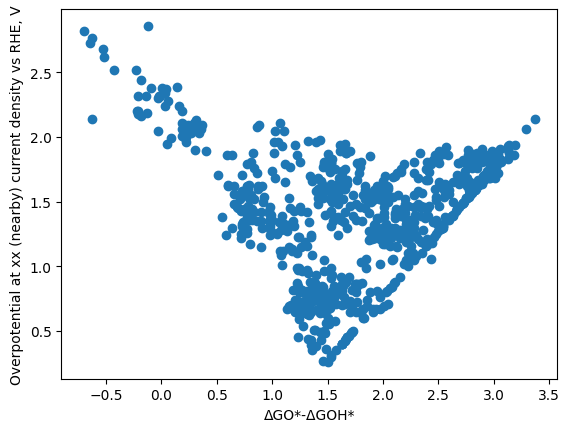

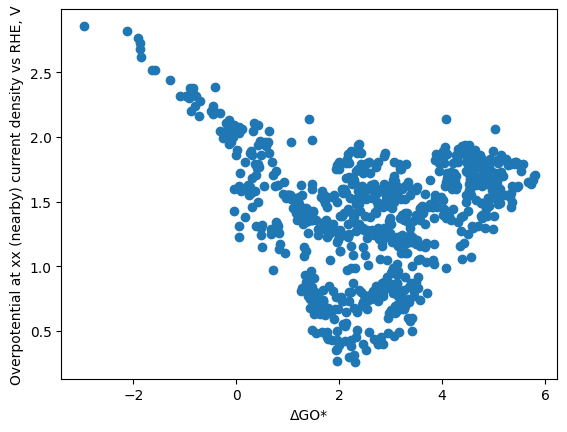

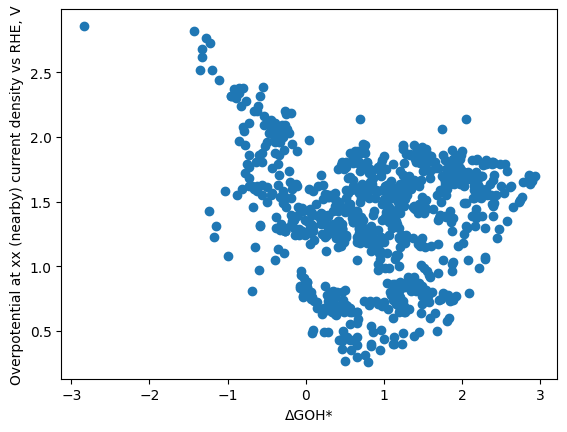

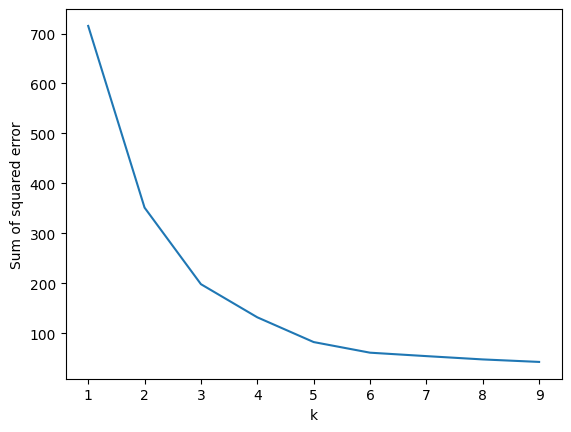

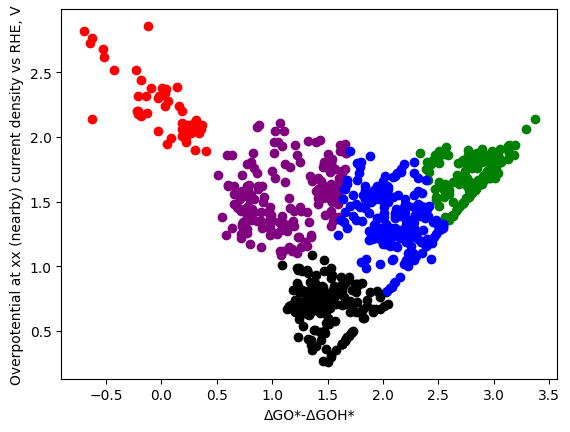

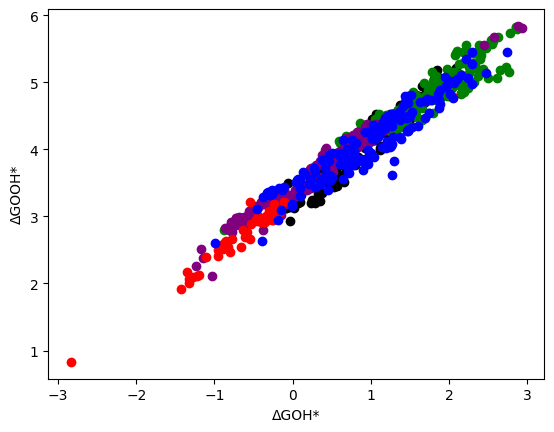

0.8164515758533752


In [239]:
#Placing functions down
plot_scatter_entropy(entropy_data)
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
linear_regression_model(entropy_data,'ΔGOH*','ΔGOOH*')

**Data exploration of optimum cluster**

In [240]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3] 
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [241]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
printing_stats_1(optimum_catalyst,entropy_data,initial_df)

The number of families in the optimum catalysts dataframe + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered initial dataframe + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial dataframe + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Tra